In [2]:
import json
import os
import plotly.express as px
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
files_name = [file_name for file_name in os.listdir('./all/') if '.json' in file_name]

dictionary = {}

for file in files_name:
    f = open(f'./all/{file}', 'r', encoding='utf-8')
    data = json.loads(f.read())
    f.close()
    data_month = data["metadata-all"]['fr']['month']
    for years in data_month:
        for month in data_month[years]:
            m = month
            if len(month)==1:
                m = '0' + month
            if f'{years}-{m}' in dictionary.keys():
                dictionary[f'{years}-{m}'] += data_month[years][str(month)]["num"]
            else:
                dictionary[f'{years}-{m}'] = data_month[years][str(month)]["num"]


sorted_keys = sorted(dictionary.keys(), reverse = True)
dict_sorted = {key:dictionary[key] for key in sorted_keys}

df = pd.DataFrame(dict_sorted.items(), columns=['Month', 'Nb of Article'])
df = df.sort_index(axis = 0, ascending = False)
print(df)

      Month  Nb of Article
36  2018-12            104
35  2019-01           4023
34  2019-02           3774
33  2019-03           3911
32  2019-04           3683
31  2019-05           3743
30  2019-06           3545
29  2019-07           3847
28  2019-08           3438
27  2019-09           3960
26  2019-10           4187
25  2019-11           3911
24  2019-12           3742
23  2020-01           3695
22  2020-02           3650
21  2020-03           3727
20  2020-04           3391
19  2020-05           3510
18  2020-06           3588
17  2020-07           3596
16  2020-08           3465
15  2020-09           3708
14  2020-10           3669
13  2020-11           3648
12  2020-12           3425
11  2021-01           3674
10  2021-02           3457
9   2021-03           3562
8   2021-04           2898
7   2021-05           2953
6   2021-06           3249
5   2021-07           3217
4   2021-08           3091
3   2021-09           3262
2   2021-10           3554
1   2021-11           3238
0

In [4]:
fig = px.bar(df,x= 'Month', y = 'Nb of Article',color="Nb of Article",color_continuous_scale=px.colors.sequential.matter)
fig.show()

In [5]:
def filterByLocKeyWord(keyWord: str, dicLoc: dict, allLocKey: dict, data_all: dict) -> None:
    for year in data_all:
        for month in data_all[year]:
            for date in data_all[year][month]:
                if keyWord in data_all[year][month][date][0]["loc"]:
                    # print(f'{year}-{month}-{date}')
                    # print(data_all[year][month][date][0]["title"])
                    # print(data_all[year][month][date][0]["loc"])
                    for loc in data_all[year][month][date][0]["loc"]:
                        if  (loc in allLocKey):
                            dicLoc[loc] = dicLoc[loc] + 1


def getLocationKey(allLocKey) -> dict:
    dictLoc = dict.fromkeys(list(allLocKey), 0)
    return dictLoc


def convertTupleToDict(listTuple):
    dico = {}
    for tuple in listTuple:
        dico[tuple[0]] = tuple[1]
    return dico


def cleanDict(dictionary: dictionary) -> dict:    
    keys = list(dictionary.keys())
    for key in keys:
        if dictionary.get(key)==0:
            dictionary.pop(key)
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return convertTupleToDict(sortedTuple) 

def firstElements(dictionary,nb):
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return dict(list(sortedTuple[0: nb]))


In [24]:
listOfDict = [] #liste des dictionnaire des localisations apparaissant dans chaque site lorsque l'on parle de la France
dictionaryLoc = {} #dictionnaire des localisations apparaissant dans tout les sites lorsque l'on parle de la France

for file in os.listdir("all"):
    f = open(f'all/{file}', 'r', encoding='utf-8')
    data = json.loads(f.read())
    f.close()

    allLocKey = data["metadata-all"]["fr"]["all"]["loc"].keys()
    dicLoc = getLocationKey(allLocKey)

    data_all = data["data-all"]
    filterByLocKeyWord('France', dicLoc, allLocKey, data_all)
    listOfDict.append(dicLoc)

    dictionaryLoc = Counter(dictionaryLoc) + Counter(dicLoc)

for d in listOfDict:
    d = cleanDict(d)

top10location = firstElements(dictionaryLoc, 20)
print(top10location)

{'France': 637, 'Paris': 97, 'États-Unis': 76, 'État': 70, 'Israël': 42, 'Russie': 36, 'Allemagne': 33, 'Algérie': 26, 'Iran': 26, 'Mali': 23, 'Europe': 22, 'Afrique': 20, 'Chine': 17, 'Royaume-Uni': 17, 'Turquie': 16, 'Alger': 16, 'République': 16, 'Sahel': 15, 'Moscou': 14, 'Italie': 14}


In [25]:
g = nx.Graph()

data = top10location
print(data.keys())
nodes = list(data.keys())
weight = list(data.values())
print(nodes)
print(weight)

dict_keys(['France', 'Paris', 'États-Unis', 'État', 'Israël', 'Russie', 'Allemagne', 'Algérie', 'Iran', 'Mali', 'Europe', 'Afrique', 'Chine', 'Royaume-Uni', 'Turquie', 'Alger', 'République', 'Sahel', 'Moscou', 'Italie'])
['France', 'Paris', 'États-Unis', 'État', 'Israël', 'Russie', 'Allemagne', 'Algérie', 'Iran', 'Mali', 'Europe', 'Afrique', 'Chine', 'Royaume-Uni', 'Turquie', 'Alger', 'République', 'Sahel', 'Moscou', 'Italie']
[637, 97, 76, 70, 42, 36, 33, 26, 26, 23, 22, 20, 17, 17, 16, 16, 16, 15, 14, 14]


In [26]:
edges = [(nodes[0], nodes[k],weight[k]**2) for k in range(1, len(nodes))]
print(edges)

[('France', 'Paris', 9409), ('France', 'États-Unis', 5776), ('France', 'État', 4900), ('France', 'Israël', 1764), ('France', 'Russie', 1296), ('France', 'Allemagne', 1089), ('France', 'Algérie', 676), ('France', 'Iran', 676), ('France', 'Mali', 529), ('France', 'Europe', 484), ('France', 'Afrique', 400), ('France', 'Chine', 289), ('France', 'Royaume-Uni', 289), ('France', 'Turquie', 256), ('France', 'Alger', 256), ('France', 'République', 256), ('France', 'Sahel', 225), ('France', 'Moscou', 196), ('France', 'Italie', 196)]


In [32]:
g = nx.Graph()
g.add_weighted_edges_from(edges)
g.add_nodes_from(nodes)
g.nodes()

NodeView(('France', 'Paris', 'États-Unis', 'État', 'Israël', 'Russie', 'Allemagne', 'Algérie', 'Iran', 'Mali', 'Europe', 'Afrique', 'Chine', 'Royaume-Uni', 'Turquie', 'Alger', 'République', 'Sahel', 'Moscou', 'Italie'))

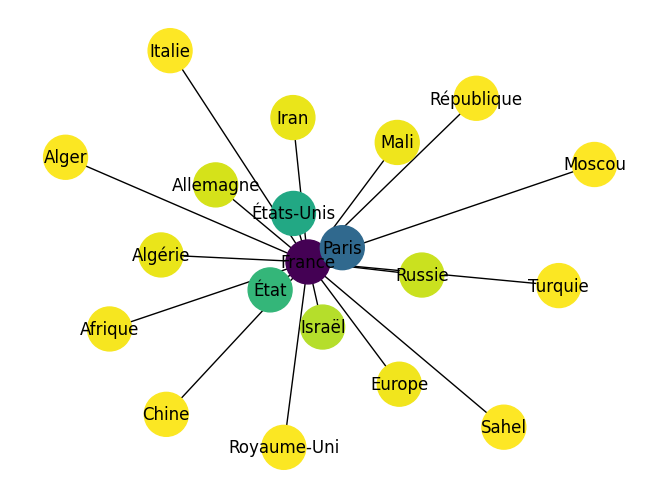

In [31]:
#color_map = ['red' if node == 'Syrie' else 'blue' for node in g]
n_weight = [i**2 for i in weight]
n_weight[0] = n_weight[1]+ n_weight[1]/2
nx.draw_spring(g,with_labels=True,node_size = 1000,node_color = n_weight,cmap = plt.cm.get_cmap('viridis_r'))